# Setup

In [1]:
import re
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.optimize import leastsq, root

In [2]:
sns.set_context("notebook")
sns.set_theme()
sns.set_palette("Set3")
sns.set(font_scale=1.3)

In [4]:
# cd ..

# Data import & preprocess

## CSV outdor records import

In [5]:
men_outdor = pd.read_csv("data/Men outdoor.csv")
women_outdor = pd.read_csv("data/Women outdoor.csv")
sprint_additional_both = pd.read_csv("data/sprint_additional.csv")

## Frame union

In [6]:
men_outdor["Sex"] = "M"
women_outdor["Sex"] = "F"
records_all = pd.concat([men_outdor, women_outdor, sprint_additional_both])

## Filter for running

In [7]:
def is_running_discip(name: str) -> bool:
    return bool(re.findall("(?i)metres?$|mile?$|marathon$", name))

In [8]:
records_run = records_all[records_all["Discipline"].apply(is_running_discip)]

## The first record and the lastest update

__It's and additional piece of info__

In [9]:
timestamps = pd.to_datetime(records_run["Date"])
timestamps.min().year, timestamps.max().year

(1965, 2023)

## Data selection

In [10]:
records_select = records_run[["Discipline", "Perf", "Sex"]].copy()
records_select = records_select.astype("string")

## Data cleansing

### Time in seconds

#### Cleanse the performace to leave only numbers, and separators.

In [11]:
str_times = records_select["Perf"].apply(
    lambda perf: "".join(re.findall(r"[\d+\.:]", perf))
)

#### Time getter function and its call.

In [12]:
def str_to_seconds(str_time):
    zero_time = datetime(1900, 1, 1)
    patterns = ["%H:%M:%S", "%M:%S", "%M:%S.%f", "%S.%f"]
    for pattern in patterns:
        try:
            time = datetime.strptime(str_time, pattern)
            delta = time - zero_time
            return delta.total_seconds()
        except ValueError:
            continue

In [13]:
records_select["T"] = str_times.apply(str_to_seconds)

#### Is anything null left?

In [14]:
records_select["T"].isnull().any()

False

### Distance in meters

#### Get the distaces from discipline name.

In [15]:
str_distances = records_select["Discipline"]

#### Define how multipliers would be translated.

In [16]:
multipliers = {
    "kilometre": 1000,
    "metre": 1,
    "mile": 1609.344,
    "marathon": 42195,
    "half": 0.5,
    "one": 1,
}

#### Distance translator function and its call.

In [17]:
def str_to_meters(str_distance):
    unit_raw = re.findall("(?i)kilometre|metre|mile|marathon", str_distance)  # unit
    modifier_raw = re.findall("(?i)one|half", str_distance)  # modifier
    number_raw = re.findall("\d+", str_distance)  # number
    unit = multipliers[unit_raw[0].lower()]
    try:
        modifier = multipliers[modifier_raw[0].lower()]
    except IndexError:
        modifier = 1
    try:
        if len(number_raw) > 0:
            number_raw_str = "".join(number_raw)
        else:
            number_raw_str = number_raw[0]
        number = int(number_raw_str)
    except IndexError:
        number = 1
    return number * unit * modifier

In [18]:
records_select["D"] = str_distances.apply(str_to_meters)

#### Is anything null left?

In [19]:
records_select["D"].isnull().any()

False

## Final data selection

### Dropping distance duplicates.

In [20]:
records_select.sort_values("T", ascending=False, inplace=True)
records_select.drop_duplicates(["D", "Sex"], keep="first", inplace=True)

### Selecting columns.

In [21]:
records = records_select[["D", "T", "Sex"]].copy()
records.reset_index(drop=True, inplace=True)
records.head()

,D,T,Sex
0,100000.0,23591.0,F
1,100000.0,22154.0,M
2,50000.0,11064.0,F
3,50000.0,9613.0,M
4,42195.0,8221.0,F


### Adding measures

In [22]:
records["pace"] = (records["T"] / 60) / (records["D"] / 1000)

## Model fit - approximated

### First phase

In [23]:
T_short = lambda D, tau, F: D / F / tau + tau

### The rest

In [24]:
T_long = (
    lambda D, E0, sigma, tau, F: (np.sqrt(E0 ** 2 + 4 * sigma * D ** 2 / tau) - E0)
    / sigma
    / 2
)

### Combined

In [25]:
def fit_params_up_to_10km(records_df, discont_penal):
    short_records = records_df[records_df["D"] <= 170].sort_values("T")
    long_records = records_df[
        (records_df["D"] >= 170) & (records_df["D"] <= 10000)
    ].sort_values("T")

    def T_short_resid(p, D, T):
        return T - T_short(D, p[0], p[1])

    short_popt, short_pcov = leastsq(
        T_short_resid, args=(short_records["D"], short_records["T"]), x0=(1, 12)
    )

    tau, F = short_popt
    T_estim_short_for_200m = T_short(200, tau, F)

    def T_long_resid(p, D, T):
        penalty = (
            np.abs(T_long(D, p[0], p[1], tau, F).iloc[0] - T_estim_short_for_200m)
            * discont_penal
        )
        return T - T_long(D, p[0], p[1], tau, F) + penalty

    long_popt, long_pcov = leastsq(
        func=T_long_resid, args=(long_records["D"], long_records["T"]), x0=(2000, 40)
    )
    E0, sigma = long_popt
    return E0, sigma, tau, F

In [26]:
def estim_D_up_to_10km(records_df, discon_penal=0):
    E0, sigma, tau, F = fit_params_up_to_10km(records_df, discon_penal)
    D_range_short = np.arange(0, 210, 10)
    D_range_long = np.arange(200, 10000, 10)
    T_short_estims = T_short(D_range_short, tau, F)
    T_long_estims = T_long(D_range_long, E0, sigma, tau, F)
    D_range = np.concatenate([D_range_short, D_range_long])
    T_range = np.concatenate([T_short_estims, T_long_estims])
    return D_range, T_range, {"E0": E0, "sigma": sigma, "tau": tau, "F": F}

In [27]:
m_D_estim, m_T_estim, m_params = estim_D_up_to_10km(
    records[records["Sex"] == "M"], discon_penal=0
)
f_D_estim, f_T_estim, f_params = estim_D_up_to_10km(
    records[records["Sex"] == "F"], discon_penal=0
)
m_D_estim_cont, m_T_estim_cont, m_params_cont = estim_D_up_to_10km(
    records[records["Sex"] == "M"], discon_penal=100
)
f_D_estim_cont, f_T_estim_cont, f_params_cont = estim_D_up_to_10km(
    records[records["Sex"] == "F"], discon_penal=100
)

# Visualization

## Some insights

### Pace vs distance

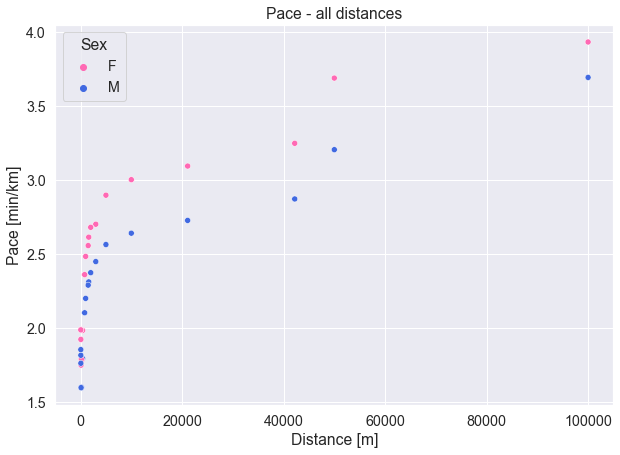

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.scatterplot(
    data=records,
    x="D",
    y="pace",
    hue="Sex",
    ax=ax,
    palette=["hotpink", "royalblue"],
)
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Pace [min/km]")
ax.set_title("Pace - all distances")
plt.show()

### Distance and time

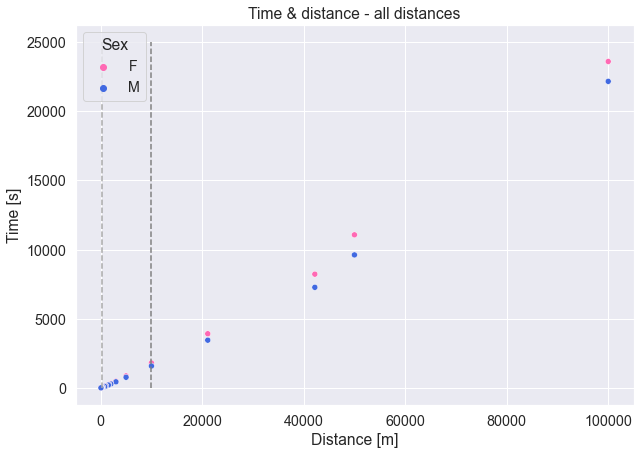

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.vlines(200, 0, 25000, colors="darkgray", ls="--")
ax.vlines(10000, 0, 25000, colors="gray", ls="--")
sns.scatterplot(
    data=records,
    x="D",
    y="T",
    hue="Sex",
    ax=ax,
    palette=["hotpink", "royalblue"],
)
ax.set_ylabel("Time [s]")
ax.set_xlabel("Distance [m]")
ax.set_title("Time & distance - all distances")
plt.show()

## Fitted times - approx

### No discont. penalty

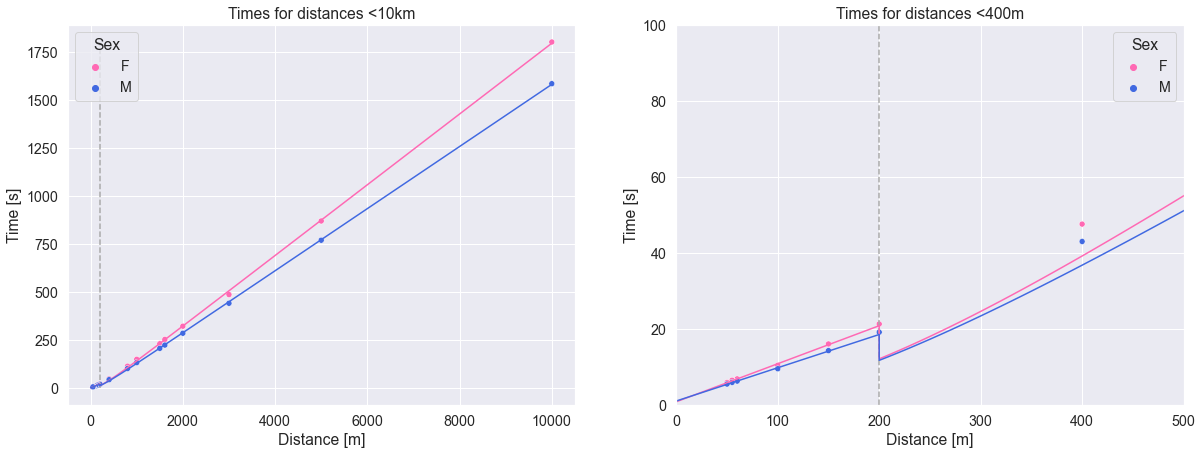

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].vlines(200, 0, 1800, colors="darkgray", ls="--")
sns.scatterplot(
    data=records[records.D <= 10000],
    x="D",
    y="T",
    hue="Sex",
    ax=ax[0],
    palette=["hotpink", "royalblue"],
)
ax[0].set_xlabel("Distance [m]")
ax[0].set_ylabel("Time [s]")
ax[0].set_title("Times for distances <10km")
ax[0].plot(f_D_estim, f_T_estim, color="hotpink")
ax[0].plot(m_D_estim, m_T_estim, color="royalblue")
# ax.set_xlim(0, 600)
# ax.set_ylim(0, 100)

ax[1].vlines(200, 0, 1800, colors="darkgray", ls="--")
sns.scatterplot(
    data=records[records.D <= 400],
    x="D",
    y="T",
    hue="Sex",
    ax=ax[1],
    palette=["hotpink", "royalblue"],
)
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylabel("Time [s]")
ax[1].set_title("Times for distances <400m")
ax[1].plot(f_D_estim, f_T_estim, color="hotpink")
ax[1].plot(m_D_estim, m_T_estim, color="royalblue")
ax[1].set_xlim(0, 500)
ax[1].set_ylim(0, 100)

plt.show()

### With discont. penalty

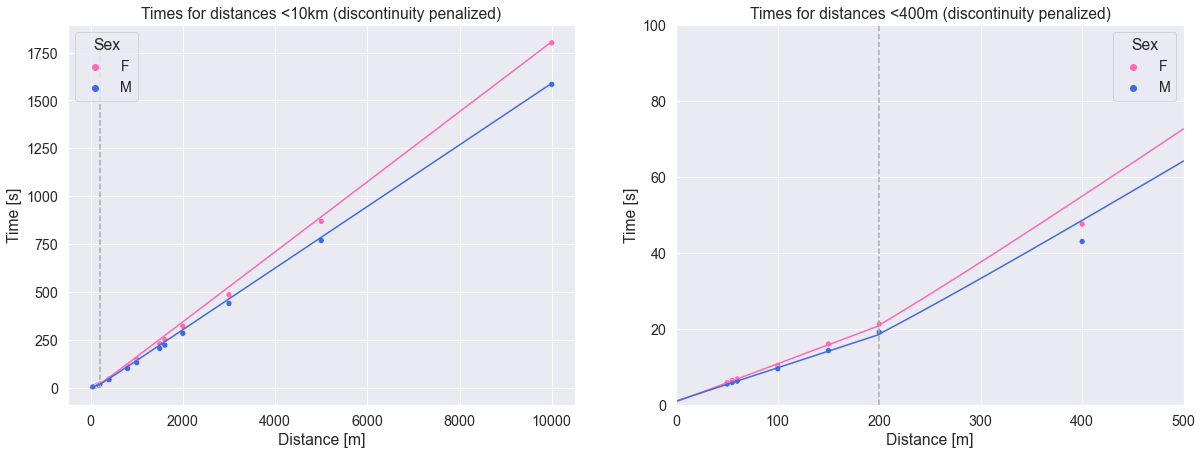

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].vlines(200, 0, 1800, colors="darkgray", ls="--")
sns.scatterplot(
    data=records[records.D <= 10000],
    x="D",
    y="T",
    hue="Sex",
    ax=ax[0],
    palette=["hotpink", "royalblue"],
)
ax[0].set_xlabel("Distance [m]")
ax[0].set_ylabel("Time [s]")
ax[0].set_title("Times for distances <10km (discontinuity penalized)")
ax[0].plot(f_D_estim_cont, f_T_estim_cont, color="hotpink")
ax[0].plot(m_D_estim_cont, m_T_estim_cont, color="royalblue")

ax[1].vlines(200, 0, 1800, colors="darkgray", ls="--")
sns.scatterplot(
    data=records[records.D <= 400],
    x="D",
    y="T",
    hue="Sex",
    ax=ax[1],
    palette=["hotpink", "royalblue"],
)
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylabel("Time [s]")
ax[1].set_title("Times for distances <400m (discontinuity penalized)")
ax[1].plot(f_D_estim_cont, f_T_estim_cont, color="hotpink")
ax[1].plot(m_D_estim_cont, m_T_estim_cont, color="royalblue")
ax[1].set_xlim(0, 500)
ax[1].set_ylim(0, 100)

plt.show()

# Estimated parameters

In [32]:
m_params_cont.update({'SEX': "M", "CONTINOUS": True})
f_params_cont.update({'SEX': "F", "CONTINOUS": True})
m_params.update({'SEX': "M", "CONTINOUS": False})
f_params.update({'SEX': "F", "CONTINOUS": False})
param_df = pd.DataFrame([m_params, f_params, m_params_cont, f_params_cont])

In [33]:
param_df

,E0,sigma,tau,F,SEX,CONTINOUS
0,2644.269872,34.312275,1.112597,10.287693,M,False
1,3209.266404,32.272943,0.911664,10.976440,F,False
2,1270.550820,34.761325,1.112597,10.287693,M,True
3,1390.382307,32.830911,0.911664,10.976440,F,True


# Future

* Residuals can be investgated (to know the accuracy).
* Get more data.
* Try another methods of LSq fitting.

\+ ofc an extended version of the model.